**LEAD University - Minería de datos**

Python Project

**Contributors**
- Carolina Salas Moreno
- Deykel Bernard Salazar
- Esteban Ramirez Montano
- Kristhel Porras Mata
- Marla Gomez Hernández


## Requirements
**Step 1:** Please install Microsoft C++ Build Tools in your machine.

**Step 2:** Install Python 3.11.7

**Step 3:** Run the following code if this is your first time running it `pip install -r requirements.txt`

# Importar las librerías

In [1]:
# Main Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import umap.umap_ as umap

# Data Optimization
from sklearn_genetic import GASearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn_genetic.space import Integer, Categorical, Continuous
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor

#Feature Selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV 

# Clustering Libraries
from abc import ABCMeta, abstractmethod
from scipy.cluster.hierarchy import dendrogram, ward, single, complete, average, linkage, fcluster
from sklearn.cluster import KMeans
from pyclustering.cluster.kmedoids import kmedoids

# Dimensionality Reduction
from prince import PCA as PCA_Prince
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Evaluation Metrics
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Classification Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor

# Additional Tools
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# EDA

In [2]:
# Análisis Exploratorio de Datos (EDA)
class EDA:
    def __init__(self, file=None):
        """
        Inicializa la clase EDA y carga datos desde un archivo CSV si se proporciona.

        Parámetros:
            file (str): Ruta al archivo CSV. Si no se proporciona, se inicializa un DataFrame vacío.
        """
        self.__df = pd.read_csv(file) if file else pd.DataFrame()

    def head_df(self, n=5):
        return self.__df.head(n) if not self.__df.empty else "No se cargaron los datos :("

    def tail_df(self, n=5):
        return self.__df.tail(n) if not self.__df.empty else "No se cargaron los datos :("

    def check_data_types(self):
        return self.__df.dtypes

    def drop_irrelevant_columns(self, columns):
        self.__df.drop(columns=columns, inplace=True)

    def drop_missing_values(self):
        self.__df.dropna(inplace=True)

    def detect_outliers(self):
        num_df = self.__df.select_dtypes(include=['float64', 'int64'])
        if num_df.empty:
            return "No hay columnas numéricas en el DataFrame."

        Q1 = num_df.quantile(0.25)
        Q3 = num_df.quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((num_df < (Q1 - 1.5 * IQR)) | (num_df > (Q3 + 1.5 * IQR))).sum()
        Dicc_outliers = {col: outliers[col] for col in num_df.columns if outliers[col] > 0}

        return Dicc_outliers if Dicc_outliers else "No se detectaron valores atípicos en las columnas numéricas."

    def plot_scatter(self, col1, col2):
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=self.__df[col1], y=self.__df[col2])
        plt.title(f'Gráfico de Dispersión: {col1} vs {col2}')
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.grid()
        plt.show()

    def plot_histogram(self, col):
        plt.figure(figsize=(10, 6))
        sns.histplot(self.__df[col], kde=True)
        plt.title(f'Histograma de {col}')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.show()

    def plot_heatmap(self):
        num_df = self.__df.select_dtypes(include=['float64', 'int64'])
        if num_df.empty:
            return "No hay columnas numéricas para generar el mapa de calor."

        num_df = num_df.loc[:, num_df.apply(lambda x: np.std(x) > 0.01)]

        plt.figure(figsize=(12, 10))
        sns.heatmap(num_df.corr(), cmap="coolwarm", annot= True, linewidths=0.5, cbar=True) #annot=False es para que no se vean los numeros en los cuadros
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.title("Correlation heatmap", fontsize=18)
        plt.ion()

    def __str__(self):
        return f"Clase EDA - DataFrame de la forma: {self.__df.shape}"

    def get_df(self):
        """Devuelve una copia del df para que las familias de los algoritmos las utilicen"""
        return self.__df.copy()

# Data Optimization

In [13]:
class DataOptimization(EDA):
    def __init__(self, datos_eda):
        """
        Use the processed DataFrame from EDA to optimize models.

        Parameters:
        - datos_eda: This is the processed DataFrame from the EDA class.
        """
        self.__df = datos_eda.get_df()
        
        # Data components
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        
        # Regression models
        self.regression_models = {
            'LinearRegression': LinearRegression(),
            #'SVR': SVR(),
            'Ridge': Ridge(),
            'DecisionTreeRegressor': DecisionTreeRegressor(),
            'RandomForestRegressor': RandomForestRegressor(),
            'GradientBoostingRegressor': GradientBoostingRegressor(),
            'XGBRegressor': XGBRegressor(random_state=42)
        }

        # Classification models
        self.classification_models = {
            'DecisionTreeClassifier': DecisionTreeClassifier(),
            'KNeighborsClassifier': KNeighborsClassifier(),
            'RandomForestClassifier': RandomForestClassifier(),
            'AdaBoostClassifier': AdaBoostClassifier(random_state=42)
        }
        
        # Current active models based on problem type (regression or classification)
        self.models = None
        
        # Parameter grids
        self.param_grids_genetic = None
        self.param_grids_exhaustive = None

        #-------------------Diccionaries with parameters for regression and classification--------------------------------------------

        self.param_grids_regression_genetic = {
            'LinearRegression': {
                "clf__copy_X": Categorical([True, False]),
                "clf__fit_intercept": Categorical([True, False]),
                "clf__positive": Categorical([True, False])
            },
            # 'SVM': { # Deshabilitado
            #     'clf__C': Continuous(0.1, 10.0),
            #     'clf__kernel': Categorical(['linear', 'poly', 'rbf']),
            #     'clf__gamma': Categorical(['scale', 'auto'])
            # },
            'Ridge': {
                'clf__alpha': Continuous(0.1, 10.0),
                'clf__fit_intercept': Categorical([True, False]),
                'clf__solver': Categorical(['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
            },
            'DecisionTreeRegressor': {
                'clf__max_depth': Integer(3, 10),
                'clf__min_samples_split': Integer(2, 10),
                'clf__min_samples_leaf': Integer(1, 5)
            },
            'RandomForestRegressor': {
                'clf__n_estimators': Integer(50, 200),
                'clf__max_features': Categorical(['sqrt', 'log2']),
                'clf__max_depth': Integer(5, 15),
                'clf__min_samples_split': Integer(2, 10)
            },
            'GradientBoostingRegressor': {
                'clf__n_estimators': Integer(50, 200),
                'clf__learning_rate': Continuous(0.01, 0.2),
                'clf__max_depth': Integer(3, 10)
            },
            'XGBRegressor': {
                'clf__learning_rate': Continuous(0.01, 0.2),
                'clf__n_estimators': Integer(50, 200),
                'clf__max_depth': Integer(3, 10),
                'clf__subsample': Continuous(0.7, 1.0)
            }
        }

        self.param_grids_regression_exhaustive = {
            'LinearRegression': {
                "clf__copy_X": [True, False],
                "clf__fit_intercept": [True, False],
                "clf__positive": [True, False]
            },
            # 'SVM': { # Deshabilitado
            #     'clf__C': [0.1, 1, 10],
            #     'clf__kernel': ['linear', 'poly', 'rbf'],
            #     'clf__gamma': ['scale', 'auto']
            # },
            'Ridge': {
                'clf__alpha': [0.1, 1.0, 10.0],
                'clf__fit_intercept': [True, False],
                'clf__solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
            },
            'DecisionTreeRegressor': {
                'clf__max_depth': [3, 5, 7, 10],
                'clf__min_samples_split': [2, 5, 10],
                'clf__min_samples_leaf': [1, 2, 5]
            },
            'RandomForestRegressor': {
                'clf__n_estimators': [50, 100, 200],
                'clf__max_features': ['sqrt', 'log2'],
                'clf__max_depth': [5, 10, 15],
                'clf__min_samples_split': [2, 5, 10]
            },
            'GradientBoostingRegressor': {
                'clf__n_estimators': [50, 100, 200],
                'clf__learning_rate': [0.01, 0.1, 0.2],
                'clf__max_depth': [3, 5, 10]
            },
            'XGBRegressor': {
                'clf__learning_rate': [0.01, 0.1, 0.2],
                'clf__n_estimators': [50, 100, 200],
                'clf__max_depth': [3, 5, 10],
                'clf__subsample': [0.7, 0.8, 1.0]
            }
        }

        self.param_grids_classification_genetic = {
            'DecisionTreeClassifier': {
                'clf__max_depth': Integer(1, 20),  # Mismo rango que el exhaustivo
                'clf__min_samples_split': Integer(2, 20),
                'clf__min_samples_leaf': Integer(1, 20),
                'clf__criterion': Categorical(['gini', 'entropy'])
            },
            'KNeighborsClassifier': {
                'clf__n_neighbors': Integer(1, 30),
                'clf__weights': Categorical(['uniform', 'distance']),
                'clf__p': Categorical([1, 2]),
                'clf__algorithm': Categorical(['ball_tree', 'kd_tree', 'brute'])
            },
            'RandomForestClassifier': {
                'clf__n_estimators': Integer(50, 300),
                'clf__max_features': Categorical(['sqrt', 'log2']),
                'clf__max_depth': Integer(5, 30),
                'clf__min_samples_split': Integer(2, 20)
            },
            'AdaBoostClassifier': {
                'clf__n_estimators': Integer(50, 300),
                'clf__learning_rate': Continuous(0.01, 2.0)
            }
        }

        self.param_grids_classification_exhaustive = {
            'DecisionTreeClassifier': {
                'clf__max_depth': [3, 5, 10, 15, 20],  # Valores discretos dentro del mismo rango
                'clf__min_samples_split': [2, 5, 10, 15, 20],
                'clf__min_samples_leaf': [1, 5, 10, 15, 20],
                'clf__criterion': ['gini', 'entropy']
            },
            'KNeighborsClassifier': {
                'clf__n_neighbors': [3, 5, 10, 20, 30],
                'clf__weights': ['uniform', 'distance'],
                'clf__p': [1, 2],
                'clf__algorithm': ['ball_tree', 'kd_tree', 'brute']
            },
            'RandomForestClassifier': {
                'clf__n_estimators': [50, 100, 200, 300],
                'clf__max_features': ['sqrt', 'log2'],
                'clf__max_depth': [5, 10, 20, 30],
                'clf__min_samples_split': [2, 5, 10, 15, 20]
            },
            'AdaBoostClassifier': {
                'clf__n_estimators': [50, 100, 200, 300],
                'clf__learning_rate': [0.01, 0.1, 0.5, 1.0, 2.0]
            }
        }

#------------------------Data Split Components--------------------------------------------------------------

    def split_df(self, target_column, test_size=None, random_state=42):
        """
        Splits the dataframe into training and test sets.

        Parameters:
        - target_column: str -> Name of the target column (y).
        - test_size: float -> Proportion of the test set (if not provided, it is calculated from the entered percentage).
        - random_state: int -> Seed for randomization.

        Returns:
        - X_train, X_test, y_train, y_test: Split and preprocessed datasets.
        """
        while True:
            try:
                percent = float(input("Enter the percentage for the training set: (Example: 80) \n"))
                if 0 < percent < 100:
                    train_size = percent / 100
                    break # Exit the loop
                else:
                    print("The percentage must be between 1 and 99.")
            except ValueError:
                print("Invalid number. Try again.")

        while True:
            try:
                # Separate features (X) and target variable (y)
                X = self.__df.drop(columns=[target_column])
                y = self.__df[target_column]
                break  # Exit the loop if there are no errors
            except KeyError:
                print(f"The column '{target_column}' does not exist. Try again.")
                print("Available columns:")
                print(self.check_data_types())
                target_column = input("Enter the correct name of the target column: ")

        # Preprocess features (X), convert categorical variables to One-Hot Encoding
        X = pd.get_dummies(X, drop_first=True)

        # Check if the target variable (y) is categorical and needs encoding
        if y.dtypes == 'object' or y.dtypes.name == 'category':
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()
            y = le.fit_transform(y)

        # Perform the split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size= 1 - train_size, random_state=random_state
        )

        print(f"Data split:\n- Training: {X_train.shape[0]} rows\n- Test: {X_test.shape[0]} rows")
        return X_train, X_test, y_train, y_test
    
#------------------------Search Components--------------------------------------------------------------

    def genetic_search(self, scoring_metric):
        """
        Optimize models using genetic algorithms.
        
        Parameters:
        - scoring_metric: str -> Metric to use for evaluation: neg_root_mean_squared_error for regression, roc_auc for classification.
        """
        if self.X_train is None or self.X_test is None:
            print("\n Error: You must run split_df() before calling genetic_search()")
            return

        results = {}
        
        # Feature selection using LassoCV for both regression and classification
        print("Performing feature selection with LassoCV...")

        lasso_cv = LassoCV(cv=5, random_state=42)
        lasso_cv.fit(self.X_train, self.y_train)
        f_selection = SelectFromModel(lasso_cv, threshold="median")

        self.X_train = f_selection.transform(self.X_train)
        self.X_test = f_selection.transform(self.X_test)

        for name, model in self.models.items():
            pl = Pipeline([ 
              ('clf', model), 
            ])            
            print(f"Training {name} with genetic method...")
            evolved_estimator = GASearchCV(
                estimator=pl,
                cv=5,
                scoring=scoring_metric,
                population_size=10,
                generations=5,
                tournament_size=3,
                elitism=True,
                crossover_probability=0.8,
                mutation_probability=0.1,
                param_grid=self.param_grids_genetic[name],
                algorithm="eaSimple",
                n_jobs=-1,
                error_score='raise',
                verbose=True
            )
            evolved_estimator.fit(self.X_train, self.y_train)
            results[name] = {
                'best_params': evolved_estimator.best_params_,
                'estimator': evolved_estimator.best_estimator_
            }
        return results

    def exhaustive_search(self, scoring_metric):
        """
        Perform exhaustive grid search for hyperparameter optimization.
        
        Parameters:
        - scoring_metric: str -> Metric to use for evaluation ('neg_root_mean_squared_error' for regression, 'roc_auc' for classification)
        """
        results = {}
        
        # Feature selection using LassoCV for both regression and classification
        print("Performing feature selection with LassoCV...")

        lasso_cv = LassoCV(cv=5, random_state=42)
        lasso_cv.fit(self.X_train, self.y_train)
        f_selection = SelectFromModel(lasso_cv, threshold="median")
            
        self.X_train = f_selection.transform(self.X_train)
        self.X_test = f_selection.transform(self.X_test)
        
        for name, model in self.models.items():
            pl = Pipeline([
              ('clf', model), 
            ])
            print(f"Training {name} with exhaustive method...")
            grid_search = GridSearchCV(
                estimator=pl,
                param_grid=self.param_grids_exhaustive[name],
                cv=5,
                scoring=scoring_metric,
                n_jobs=-1,
                verbose=1
            )
            grid_search.fit(self.X_train, self.y_train)
            results[name] = {
                'best_params': grid_search.best_params_,
                'estimator': grid_search.best_estimator_
            }
        return results
    
#------------------------Director Function--------------------------------------------------------------
    def opti_director(self, target_column, problem_type='regression', method='both', random_state=42):
        """
        This method orchestrates the optimization process for every model in this class.
        1. Make the data split
        2. Performs the optimization of models (genetic, exhaustive or both)
        3. Extract the best parameters in a clean format to use them in the models.
        
        Parameters:
        - target_column: str -> Name of the target column (y).
        - problem_type: str -> Type of problem ('regression' or 'classification').
        - method: str -> What optimization method is going to be used ('genetic', 'exhaustive', or 'both').
        - random_state: int -> Random seed for reproducibility.
        
        Returns:
        - dict -> Keeps the best parameters for each model.
        """
        # Set up models and parameter grids based on problem type
        if problem_type.lower() == 'regression':
            self.models = self.regression_models
            self.param_grids_genetic = self.param_grids_regression_genetic
            self.param_grids_exhaustive = self.param_grids_regression_exhaustive
            # RMSE for regression
            scoring_metric = 'neg_root_mean_squared_error'  
        elif problem_type.lower() == 'classification':
            self.models = self.classification_models
            self.param_grids_genetic = self.param_grids_classification_genetic
            self.param_grids_exhaustive = self.param_grids_classification_exhaustive
            # AUC for classification
            scoring_metric = 'roc_auc'  
        else:
            raise ValueError("problem_type must be 'regression' or 'classification'")
        
        # 1. Make the data split
        self.X_train, self.X_test, self.y_train, self.y_test = self.split_df(
            target_column=target_column,
            random_state=random_state
        )
        
        # 2. Performs the optimization of models (genetic, exhaustive or both)
        best_params = {}
        
        if method.lower() == 'genetic' or method.lower() == 'both':
            genetic_results = self.genetic_search(scoring_metric)
            
            # 3. Extract the best parameters in a clean format
            clean_genetic_params = {}
            for model_name, model_result in genetic_results.items():
                best_params_model = model_result['best_params']
                # Eliminar el prefijo 'clf__' de los nombres de los parámetros
                model_params = {param.replace('clf__', ''): value for param, value in best_params_model.items()}
                clean_genetic_params[model_name] = model_params
            best_params['genetic'] = clean_genetic_params
            
        if method.lower() == 'exhaustive' or method.lower() == 'both':
            exhaustive_results = self.exhaustive_search(scoring_metric)
            
            # 3. Extract the best parameters in a clean format
            clean_exhaustive_params = {}
            for model_name, model_result in exhaustive_results.items():
                best_params_model = model_result['best_params']
                # Eliminar el prefijo 'clf__' de los nombres de los parámetros
                model_params = {param.replace('clf__', ''): value for param, value in best_params_model.items()}
                clean_exhaustive_params[model_name] = model_params
            best_params['exhaustive'] = clean_exhaustive_params
            
        print("\n----- MEJORES PARÁMETROS ENCONTRADOS -----")

        if 'genetic' in best_params:
            print("\n=== MÉTODO GENÉTICO ===")
            for model_name, params in best_params['genetic'].items():
                print(f"{model_name}:")
                for param_name, value in params.items():
                    print(f"  {param_name}: {value}")

        if 'exhaustive' in best_params:
            print("\n=== MÉTODO EXHAUSTIVO ===")
            for model_name, params in best_params['exhaustive'].items():
                print(f"{model_name}:")
                for param_name, value in params.items():
                    print(f"  {param_name}: {value}")

        return best_params

# Models

## Unsupervised

In [ ]:
class NoSupervisado(EDA):
    def __init__(self, datos_eda):
        df = datos_eda.get_df()
        super().__init__()
        self.__df = df

    @property
    def df(self):
        return self.__df

    @df.setter
    def df(self, p_df):
        self.__df = p_df

    def __byebye_object_values(self):
        # Delete object columns
        self.__df = self.__df.select_dtypes(exclude=['object'])

    def calcular_metricas(self, labels):
        """
        Calcula métricas de evaluación para clustering.
        """
        data = self.__df.dropna()
        data = (data - data.mean()) / data.std()
        metrics = {
            "Índice de Silueta": silhouette_score(data, labels),
            "Calinski-Harabasz": calinski_harabasz_score(data, labels),
            "Davies-Bouldin": davies_bouldin_score(data, labels)
        }
        return metrics

    def kmeans(self, n_clusters):
        self.__byebye_object_values()
        data = self.__df
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(data)
        metrics = self.calcular_metricas(labels)
        print(f"Métricas para K-Means (n_clusters={n_clusters}): {metrics}")
        return metrics

    def k_medoids(self, n_clusters, metric='euclidean'):
        self.__byebye_object_values()
        data = self.__df
        
        # Convertir a numpy array si aún no lo es
        data_array = np.array(data)
        
        # Inicialización de medoides (seleccionar índices aleatorios)
        np.random.seed(42)  # Para reproducibilidad
        initial_medoids = np.random.choice(len(data_array), n_clusters, replace=False).tolist()
        
        # Crear y ejecutar el algoritmo KMedoids
        kmedoids_instance = kmedoids(data_array, initial_medoids)
        kmedoids_instance.process()
        
        # Obtener clusters y medoides
        clusters = kmedoids_instance.get_clusters()  # Lista de listas de índices
        medoids = kmedoids_instance.get_medoids()    # Lista de índices de medoides
        
        # Crear etiquetas en formato sklearn (un número para cada punto)
        labels = np.zeros(len(data_array), dtype=int)
        for cluster_idx, cluster in enumerate(clusters):
            for point_idx in cluster:
                labels[point_idx] = cluster_idx
        
        # Calcular métricas
        metrics = self.calcular_metricas(labels)
        print(f"Métricas para K-Medoids (n_clusters={n_clusters}, metric={metric}): {metrics}")
        
        return metrics

    def hac(self, n_clusters=3, method='ward'):
        self.__byebye_object_values()
        data = self.__df
        linkage_matrix = linkage(data, method=method)
        labels = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
        metrics = self.calcular_metricas(labels)
        print(f"Métricas para HAC (n_clusters={n_clusters}, method={method}): {metrics}")
        return metrics

    def umap_model(self, n_components=2, n_neighbors=15):
        self.__byebye_object_values()
        data = self.__df
        modelo_umap = UMAP(n_components=n_components, n_neighbors=n_neighbors)
        components = modelo_umap.fit_transform(data)
        kmeans = KMeans(n_clusters=3, random_state=42)
        labels = kmeans.fit_predict(components)
        metrics = self.calcular_metricas(labels)
        print(f"Métricas para UMAP (n_components={n_components}, n_neighbors={n_neighbors}): {metrics}")
        return metrics

    def comparar_algoritmos(self, n_clusters):

        if self.__df.isnull().any().any():
          print("El DataFrame contiene valores nulos. Se eliminarán automáticamente para continuar.")
          self.__df.dropna(inplace=True)

        print("\nEjecutando K-Means...")
        kmeans_metrics = self.kmeans(n_clusters)

        print("\nEjecutando K-Medoids...")
        kmedoids_metrics = self.k_medoids(n_clusters)

        print("\nEjecutando HAC...")
        hac_metrics = self.hac(n_clusters=n_clusters)

        print("\nEjecutando UMAP...")
        umap_metrics = self.umap_model(n_components=2, n_neighbors=15)

        resultados = pd.DataFrame({
            "K-Means": kmeans_metrics,
            "K-Medoids": kmedoids_metrics,
            "HAC": hac_metrics,
            "UMAP": umap_metrics
        }).T

        print("\nComparación de Algoritmos:")
        print(resultados)
        return resultados

## Supervised 

In [ ]:
class Supervisado:
    def __init__(self, data_optimization, best_params=None):
        """
        Initialize the Supervisado class with data and optimized parameters from DataOptimization
        
        Parameters:
        - data_optimization: Instance of DataOptimization with optimized models and data
        """

        self.resultados = {}

        # Store the data splits from DataOptimization
        self.X_train = data_optimization.X_train
        self.X_test = data_optimization.X_test
        self.y_train = data_optimization.y_train
        self.y_test = data_optimization.y_test
        
        # Store the best parameters from optimization
        self.best_params = best_params
        
        # Detects automatically if the problem is regression or classification using the dictionary
        # obtained from the DataOptimization class
        self.problem_type = 'regression' if 'Regressor' in list(data_optimization.models.keys())[0] or list(data_optimization.models.keys())[0] in ['LinearRegression', 'Lasso', 'Ridge'] else 'classification'
        
        # Results storage for comparison
        self.all_model_results = []

        # Define classification models dictionary for easier iteration
        self.classification_models = {
            'DecisionTreeClassifier': {
                'model_class': DecisionTreeClassifier,
                'default_params': {'random_state': 42}
            },
            'KNeighborsClassifier': {
                'model_class': KNeighborsClassifier,
                'default_params': {}
            },
            'RandomForestClassifier': {
                'model_class': RandomForestClassifier,
                'default_params': {'random_state': 42}
            },
            'AdaBoostClassifier': {
                'model_class': AdaBoostClassifier,
                'default_params': {'random_state': 42}
            }
        }
        
        # Define regression models dictionary for easier iteration
        self.regression_models = {
            'LinearRegression': {
                'model_class': LinearRegression,
                'default_params': {},
                'display_name': 'Regresión Lineal Simple'
            },
            'Ridge': {
                'model_class': Ridge,
                'default_params': {'alpha': 1.0},
                'display_name': 'Regresión Ridge'
            },
            'DecisionTreeRegressor': {
                'model_class': DecisionTreeRegressor,
                'default_params': {'random_state': 0},
                'display_name': 'Decision Tree Regressor'
            },
            'RandomForestRegressor': {
                'model_class': RandomForestRegressor,
                'default_params': {'max_depth': 2, 'random_state': 0},
                'display_name': 'Random Forest Regressor'
            },
            'GradientBoostingRegressor': {
                'model_class': GradientBoostingRegressor,
                'default_params': {'random_state': 0},
                'display_name': 'Gradient Boosting Regressor'
            },
            'XGBRegressor': {
                'model_class': XGBRegressor,
                'default_params': {'random_state': 0},
                'display_name': 'XGBoost Regressor'
            }
        }


    @property
    def df(self):
        return self.__df

    @df.setter
    def df(self, p_df):
        self.__df = p_df

#-----------------Evaluating Models----------------------------
    def regre_metrics(self, modelo, X_test, y_test, predicciones, model_name):
      """
      Calculate the model evaluation metrics and save the results in a dictionary.

      Parameters:
      - modelo: The model in use
      - X_test: Test features
      - y_test: Test labels
      - predicciones: Model predictions
      - model_name: Model name

      Returns:
      - resultados: Dictionary containing evaluation metrics.
      """
      # Regression metrics
      mse = mean_squared_error(y_test, predicciones)
      r2 = r2_score(y_test, predicciones)
      mae = mean_absolute_error(y_test, predicciones)
      rmse = np.sqrt(mse)

      # Calculate global precision
      tolerancia = 0.1  # 10% of tolerance
      precision_global = np.mean(np.abs(y_test - predicciones) <= (tolerancia * y_test)) * 100

      resultados = {
          'modelo': model_name,
          'MSE': mse,
          'R2': r2,
          'MAE': mae,
          'RMSE': rmse,
          'precision_global': precision_global,
          #'predicciones': predicciones.tolist(),
          #'valores_reales': y_test.tolist()
      }
      return resultados

    def classi_metrics(self, modelo, X_test, y_test, predicciones, model_name):
        """
        Calculate evaluation metrics for classification models and store the results in a dictionary.

        Parameters:
        - y_test: True labels of the test dataset.
        - predicciones: Predicted labels from the classification model.
        - model_name: Name or identifier of the evaluated model.

        Returns:
        - resultados: Dictionary containing evaluation metrics.
        """
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

        accuracy = accuracy_score(y_test, predicciones)
        precision = precision_score(y_test, predicciones, average='weighted', zero_division=0)
        recall = recall_score(y_test, predicciones, average='weighted', zero_division=0)
        f1 = f1_score(y_test, predicciones, average='weighted', zero_division=0)

        # Define auc variable before conditional block to avoid UnboundLocalError
        auc = None
        
        # Calculate AUC if it's a binary classification problem
        if hasattr(modelo, "predict_proba") and len(np.unique(y_test)) == 2:
            try:
                y_proba = modelo.predict_proba(X_test)[:, 1]
                auc = roc_auc_score(y_test, y_proba)
            except:
                # If there some error calculating AUC, roc_auc = None
                pass

        resultados = {
            'modelo': model_name,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': auc
        }

        return resultados


#------------------------Running Regression Algorithms--------------------------------------------------------------
    def regre_operator(self, model_key, X_train, X_test, y_train, y_test, compare_params=False):
        """
        Method to run any regression model based on the key from regression_models dictionary.
        
        Parameters:
        - model_key: Key of the model in regression_models dictionary
        - X_train, X_test: Features for training/testing
        - y_train, y_test: Target variables for training/testing
        - compare_params: Enables parameter comparison if True
        
        Returns:
        - List of dictionaries with evaluation metrics
        """
        if model_key not in self.regression_models:
            print(f"Error: Modelo '{model_key}' no encontrado en regression_models.")
            return []
            
        model_info = self.regression_models[model_key]
        display_name = model_info.get('display_name', model_key)
        
        print(f"Starting {display_name}...")
        
        results = []
        
        # 1. Default parameters
        default_model = model_info['model_class'](**model_info['default_params'])
        default_model.fit(X_train, y_train)
        default_preds = default_model.predict(X_test)
        default_results = self.regre_metrics(
            default_model, X_test, y_test, default_preds, f'{display_name} (Default)')
        results.append(default_results)
        
        if compare_params and self.best_params:
            # 2. Genetic parameters if available
            if 'genetic' in self.best_params and model_key in self.best_params['genetic']:
                gen_params = self.best_params['genetic'][model_key]
                # Merge default params with genetic params (genetic params take precedence)
                gen_all_params = {**model_info['default_params'], **gen_params}
                
                gen_model = model_info['model_class'](**gen_all_params)
                gen_model.fit(X_train, y_train)
                gen_preds = gen_model.predict(X_test)
                gen_results = self.regre_metrics(
                    gen_model, X_test, y_test, gen_preds, f'{display_name} (Genetic)')
                results.append(gen_results)
            
            # 3. Exhaustive parameters if available
            if 'exhaustive' in self.best_params and model_key in self.best_params['exhaustive']:
                ex_params = self.best_params['exhaustive'][model_key]
                # Merge default params with exhaustive params (exhaustive params take precedence)
                ex_all_params = {**model_info['default_params'], **ex_params}
                
                ex_model = model_info['model_class'](**ex_all_params)
                ex_model.fit(X_train, y_train)
                ex_preds = ex_model.predict(X_test)
                ex_results = self.regre_metrics(
                    ex_model, X_test, y_test, ex_preds, f'{display_name} (Exhaustive)')
                results.append(ex_results)
        
        return results

#------------------------ Running Classification Algorithms---------------------------------------------------------

    def classi_operator(self, model_key, X_train, X_test, y_train, y_test, compare_params=False):
        """
        Generic classification method that works with any classification model.
        
        Parameters:
        - model_key: Algorithms stored in the classification_models dictionary
        - X_train, X_test: Features for training/testing
        - y_train, y_test: Labels for training/testing
        - compare_params: Enables parameter comparison if True
        
        Returns:
        - List of dictionaries with evaluation metrics
        """
        if model_key not in self.classification_models:
            print(f"Error: Modelo '{model_key}' no encontrado en classification_models.")
            return []
            
        model_info = self.classification_models[model_key]
        print(f"Starting {model_key}...")
        
        results = []
        
        # 1. Default parameters
        default_model = model_info['model_class'](**model_info['default_params'])
        default_model.fit(X_train, y_train)
        default_preds = default_model.predict(X_test)
        default_results = self.classi_metrics(
            default_model, X_test, y_test, default_preds, f'{model_key} (Default)')
        results.append(default_results)
        
        if compare_params and self.best_params:
            # 2. Genetic parameters if available
            if 'genetic' in self.best_params and model_key in self.best_params['genetic']:
                gen_params = self.best_params['genetic'][model_key]
                # Merge default params with genetic params (genetic params take precedence)
                gen_all_params = {**model_info['default_params'], **gen_params}
                
                gen_model = model_info['model_class'](**gen_all_params)
                gen_model.fit(X_train, y_train)
                gen_preds = gen_model.predict(X_test)
                gen_results = self.classi_metrics(
                    gen_model, X_test, y_test, gen_preds, f'{model_key} (Genetic)')
                results.append(gen_results)
            
            # 3. Exhaustive parameters if available
            if 'exhaustive' in self.best_params and model_key in self.best_params['exhaustive']:
                ex_params = self.best_params['exhaustive'][model_key]
                # Merge default params with exhaustive params (exhaustive params take precedence)
                ex_all_params = {**model_info['default_params'], **ex_params}
                
                ex_model = model_info['model_class'](**ex_all_params)
                ex_model.fit(X_train, y_train)
                ex_preds = ex_model.predict(X_test)
                ex_results = self.classi_metrics(
                    ex_model, X_test, y_test, ex_preds, f'{model_key} (Exhaustive)')
                results.append(ex_results)
        
        return results
      
    def model_director(self, compare_params=False):
        """
        Executes all models and stores the results in a list: all_model_results.

        Parameters:
        - compare_params: bool, default False. If True, compare default and optimized parameters.
        
        Returns:
        - List of dictionaries containing evaluation metrics for each executed model
        """
        # Print information about the data being used
        print(f"Evaluating models with X_train: {self.X_train.shape}, X_test: {self.X_test.shape}")

        # Clean old results
        self.all_model_results = []

        # Execute models based on problem type
        if self.problem_type == 'classification':
            # Execute each classification model
            for model_key in self.classification_models.keys():
                results = self.classi_operator(
                    model_key, 
                    self.X_train, 
                    self.X_test,
                    self.y_train, 
                    self.y_test,
                    compare_params=compare_params
                )
                if results:
                    self.all_model_results.extend(results)
                    
            # Determine best model based on ROC AUC (for binary classification) or accuracy
            if self.all_model_results:
                if 'roc_auc' in self.all_model_results[0] and self.all_model_results[0]['roc_auc'] is not None:
                    best_model = max(self.all_model_results, key=lambda x: x['roc_auc'] if x['roc_auc'] is not None else -1)
                    print(f"\nBest model (based on ROC AUC): {best_model['modelo']} with ROC AUC: {best_model['roc_auc']:.4f}")
                else:
                    best_model = max(self.all_model_results, key=lambda x: x['accuracy'])
                    print(f"\nBest model (based on accuracy): {best_model['modelo']} with accuracy: {best_model['accuracy']:.4f}")
                    
        else:  # regression
            # Execute each regression model
            for model_key in self.regression_models.keys():

                # Just for checking the data shape :)
                print(f"Model {model_key} - Processing data with shape: X_train={self.X_train.shape}, X_test={self.X_test.shape}")

                results = self.regre_operator(
                    model_key,
                    self.X_train, 
                    self.X_test,
                    self.y_train, 
                    self.y_test,
                    compare_params=compare_params
                )
                if results:
                    self.all_model_results.extend(results)
            
            # Determine best model based on RMSE (lower is better)
            if self.all_model_results:
                best_model = min(self.all_model_results, key=lambda x: x['RMSE'])
                print(f"\nBest model (based on RMSE): {best_model['modelo']} with RMSE: {best_model['RMSE']:.4f}")
        
        return self.all_model_results

# Prueba para visualizar
    def visualizar_comparacion_modelos(self, metrica='accuracy', figsize=(12, 8), guardar_grafico=False, ruta_guardado=None):
        if not self.all_model_results:
            print("No hay resultados disponibles. Ejecuta model_director primero.")
            return None, None
        
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        
        # Detectar si estamos trabajando con regresión o clasificación
        is_regression = 'RMSE' in self.all_model_results[0]
        
        # Configurar la métrica por defecto según el tipo de problema
        if is_regression and metrica == 'accuracy':
            metrica = 'RMSE'
            print("Detectado problema de regresión. Usando métrica RMSE por defecto.")
        
        modelos = []
        valores = []
        categorias = []
        
        for resultado in self.all_model_results:
            nombre_completo = resultado.get('modelo')
            
            if metrica not in resultado:
                continue
                
            if '(' in nombre_completo:
                nombre_base = nombre_completo.split('(')[0].strip()
                optimizacion = nombre_completo.split('(')[1].replace(')', '').strip()
            else:
                nombre_base = nombre_completo
                optimizacion = 'Default'
            
            modelos.append(nombre_base)
            
            # Para RMSE, valores menores son mejores, así que invertimos para la visualización
            if metrica in ['RMSE', 'MSE', 'MAE']:
                valores.append(-resultado[metrica] if resultado[metrica] is not None else 0)
            else:
                valores.append(resultado[metrica] if resultado[metrica] is not None else 0)
            
            categorias.append(optimizacion)
        
        df = pd.DataFrame({
            'Modelo': modelos,
            'Valor': valores,
            'Categoría': categorias
        })
        
        modelos_unicos = sorted(df['Modelo'].unique())
        categorias_unicas = ['Default', 'Genetic', 'Exhaustive']
        
        fig, ax = plt.subplots(figsize=figsize)
        
        ancho_barra = 0.25
        indice = np.arange(len(modelos_unicos))
        offsets = np.linspace(-ancho_barra, ancho_barra, len(categorias_unicas))
        
        for i, categoria in enumerate(categorias_unicas):
            datos_categoria = df[df['Categoría'] == categoria]
            if datos_categoria.empty:
                continue
                
            valores_por_modelo = dict(zip(datos_categoria['Modelo'], datos_categoria['Valor']))
            valores_a_plotear = [valores_por_modelo.get(modelo, 0) for modelo in modelos_unicos]
            
            ax.bar(indice + offsets[i], valores_a_plotear, ancho_barra, 
                label=f'{categoria}',
                alpha=0.7)
        
        ax.set_xlabel('Algoritmos')
        
        if metrica in ['RMSE', 'MSE', 'MAE']:
            ax.set_ylabel(f'Valor de {metrica} (invertido)')
            ax.set_title(f'Comparación de Modelos - Métrica: {metrica} (valores más bajos son mejores)')
        else:
            ax.set_ylabel(f'Valor de {metrica}')
            ax.set_title(f'Comparación de Modelos - Métrica: {metrica}')
        
        ax.set_xticks(indice)
        ax.set_xticklabels(modelos_unicos, rotation=45, ha='right')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.3)
        
        for i, categoria in enumerate(categorias_unicas):
            datos_categoria = df[df['Categoría'] == categoria]
            if datos_categoria.empty:
                continue
                
            valores_por_modelo = dict(zip(datos_categoria['Modelo'], datos_categoria['Valor']))
            
            for j, modelo in enumerate(modelos_unicos):
                if modelo in valores_por_modelo:
                    valor = valores_por_modelo[modelo]
                    if metrica in ['RMSE', 'MSE', 'MAE']:
                        etiqueta = f'{-valor:.3f}'
                    else:
                        etiqueta = f'{valor:.3f}'
                    ax.text(j + offsets[i], valor + (0.01 * np.sign(valor)), etiqueta, 
                        ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        
        if guardar_grafico and ruta_guardado:
            plt.savefig(ruta_guardado, dpi=300, bbox_inches='tight')
            print(f"Gráfico guardado en: {ruta_guardado}")
        
        return fig, ax

# Testing

Data split:
- Training: 2350 rows
- Test: 588 rows
Performing feature selection with LassoCV...
Training LinearRegression with genetic method...


c:\Users\esteb\Documents\GitHub\MineriaAvanzada\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\esteb\Documents\GitHub\MineriaAvanzada\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	-7.01102	0.434453   	-6.20459   	-7.60941   
1  	8     	-6.73005	0.410193   	-6.20459   	-7.60941   
2  	4     	-6.4734 	0.455448   	-6.20459   	-7.60941   
3  	7     	-6.26875	0.19249    	-6.20459   	-6.84622   
4  	3     	-6.34507	0.421447   	-6.20459   	-7.60941   
5  	9     	-6.34507	0.421447   	-6.20459   	-7.60941   
Training Ridge with genetic method...
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	-13.8553	4.93592    	-6.84446   	-18.8677   
1  	3     	-11.2725	4.34195    	-6.84446   	-18.5281   
2  	6     	-8.78031	2.78011    	-6.84446   	-14.3787   
3  	6     	-7.77144	2.07257    	-6.84446   	-13.551    
4  	6     	-6.84412	0.00100638 	-6.8411    	-6.84446   
5  	8     	-6.84345	0.00153727 	-6.8411    	-6.84446   
Training DecisionTreeRegressor with genetic method...
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	-4.88167	0.511863   	-4.48474   	-5.65922   
1  	8     	-

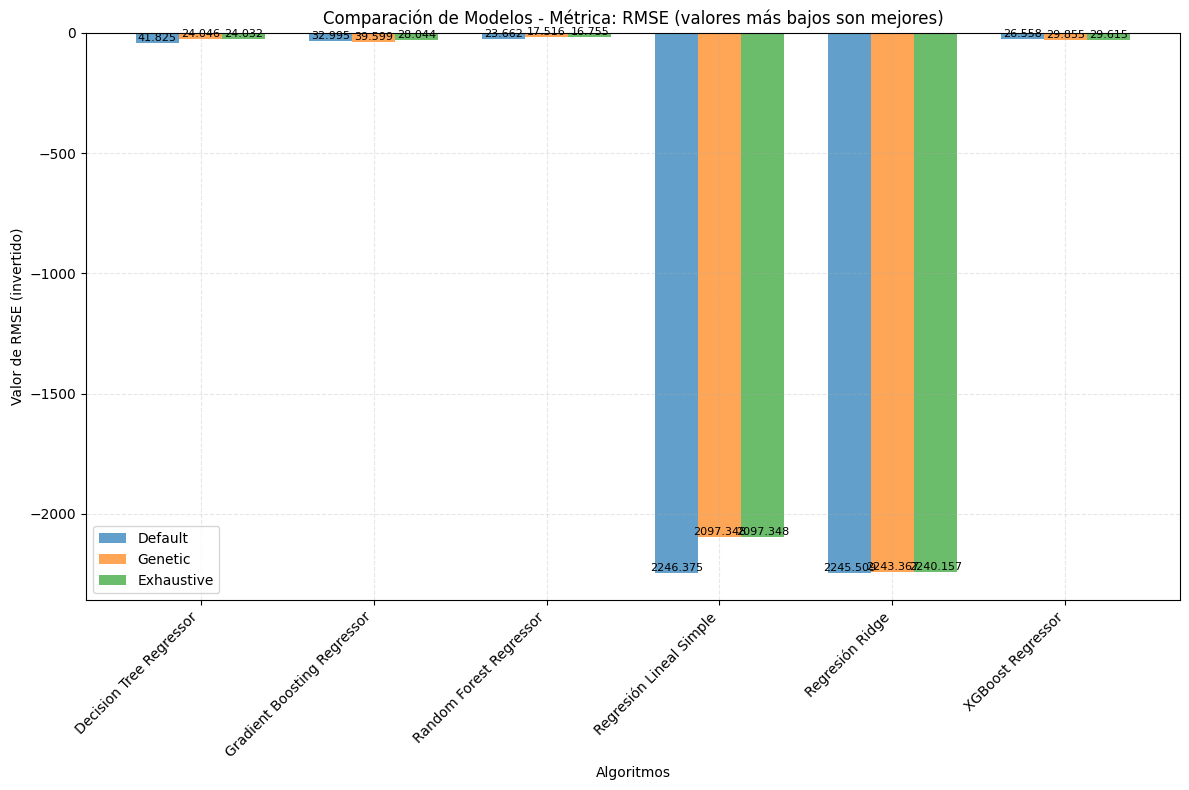

In [31]:
# MI TESTING
# 1. Cargar el archivo CSV con EDA
archivo_csv = "../dataset/dataset.csv"
eda = EDA(file=archivo_csv)

# 2. Pasar el EDA al optimizador
optimizador = DataOptimization(eda)

# 3. Ejecutar optimización y obtener los mejores parámetros
best_params = optimizador.opti_director(
    target_column='Price',         
    problem_type='regression',      
    method='both'                      
)

# 4. Crear la instancia del modelo supervisado pasando los mejores parámetros
modelo = Supervisado(optimizador, best_params=best_params)

# 5. Ejecutar los modelos de clasificación y comparar variantes
modelo.model_director(compare_params=True)

# 7. Visualizar la comparación usando ROC AUC
print("\nGenerando visualización comparativa...")
fig, ax = modelo.visualizar_comparacion_modelos()

# 8. Mostrar gráfico
import matplotlib.pyplot as plt
plt.show()